In [102]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# https://www.kaggle.com/code/weipengzhang/download-and-preprocess-data

In [103]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [104]:
print('device:', device)

device: cpu


In [105]:
train_path = "data/cake-classification/images/train" 
test_path = "data/cake-classification/images/test"

In [106]:
training_tr = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_tr = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
train_dataset = datasets.ImageFolder(train_path, training_tr)
dataset = datasets.ImageFolder(test_path, test_tr)


In [107]:
test_dataset, val_dataset = random_split(dataset, [int(len(dataset)*0.6), int(len(dataset)*0.4)])

In [108]:
print('train_dataset:', len(train_dataset))
print('test_dataset:', len(test_dataset))
print('val_dataset:', len(val_dataset))

train_dataset: 1500
test_dataset: 180
val_dataset: 120


In [109]:
batch_size = 4
trainloader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

testloader = DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

In [110]:
classes = train_dataset.classes

In [111]:
classes

['apple_pie',
 'cannoli',
 'carrot_cake',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'creme_brulee',
 'cup_cakes',
 'donuts',
 'ice_cream',
 'macarons',
 'panna_cotta',
 'red_velvet_cake',
 'tiramisu',
 'waffles']

In [112]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(testloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes[x] for x in labels])

NameError: name 'testloader' is not defined

In [114]:
import time
from tempfile import TemporaryDirectory

In [115]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in (trainloader if phase == 'train' else valloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / (len(train_dataset) if phase == 'train' else len(val_dataset))
                epoch_acc = running_corrects.double() / (len(train_dataset) if phase == 'train' else len(val_dataset))

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [116]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for _, (inputs, labels) in enumerate(valloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
           
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]} original: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [117]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [118]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 15)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=1, gamma=0.1)

In [119]:
model_ft = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------


train Loss: 1.6829 Acc: 0.4887
val Loss: 0.5749 Acc: 0.8417

Epoch 1/2
----------
train Loss: 0.9396 Acc: 0.7320
val Loss: 0.4033 Acc: 0.8917

Epoch 2/2
----------
train Loss: 0.8111 Acc: 0.7540
val Loss: 0.3943 Acc: 0.8917

Training complete in 14m 22s
Best val Acc: 0.891667


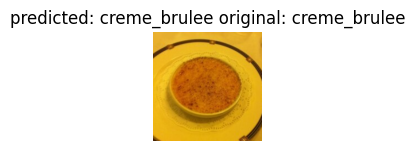

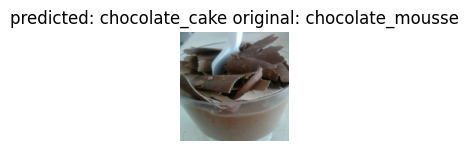

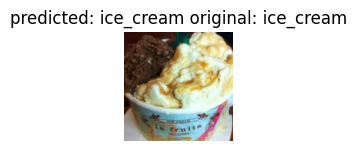

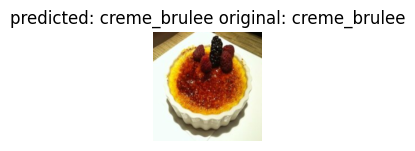

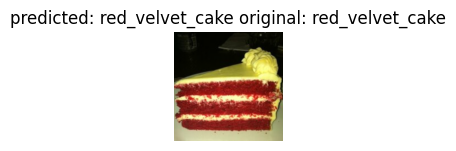

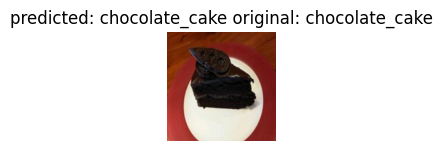

In [120]:
visualize_model(model_ft)

In [121]:
def test_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return round(100 * correct / total, 2)


In [122]:
accuracy = test_accuracy(model_ft, testloader, device)
print(f'Accuracy of the network on the test images: {accuracy} %')

Accuracy of the network on the test images: 88.89 %


### Feature extractor 


In [123]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# Freeze all layers except the fully connected layers
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 15)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=1, gamma=0.1)

In [124]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 2.0382 Acc: 0.3607
val Loss: 0.9391 Acc: 0.6750

Epoch 1/2
----------
train Loss: 1.2928 Acc: 0.6493
val Loss: 0.6704 Acc: 0.8417

Epoch 2/2
----------
train Loss: 1.2697 Acc: 0.6667
val Loss: 0.6535 Acc: 0.8500

Training complete in 4m 6s
Best val Acc: 0.850000


In [125]:
from PIL import Image

In [126]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = test_tr(img)
    img = img.unsqueeze(0)

    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {classes[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

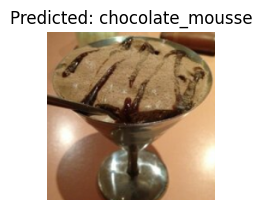

In [127]:
visualize_model_predictions(
    model_ft,
    img_path='data/cake-classification/images/test/chocolate_mousse/3088782.jpg'
)

plt.ioff()
plt.show()

In [128]:
accuracy = test_accuracy(model_conv, testloader, device)
print(f'Accuracy of the network on the test images: {accuracy} %')

Accuracy of the network on the test images: 85.0 %
